<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [202]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_curve
import copy
import joblib

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [203]:
start = '20120101'
end = '20231231'
match_type = 'm'

In [204]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

RD_CUTOFF = 125

df = pd.read_csv('../testcsvs/glickoUpdated.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]
df = df[(df['a_surface_glicko_rd'] <= RD_CUTOFF) & (df['b_surface_glicko_rd'] <= RD_CUTOFF) & (df['a_glicko_rd'] <= RD_CUTOFF) & (df['b_glicko_rd'] <= RD_CUTOFF)]


df = df.drop(['tourney_id', 'tourney_name', 'match_num', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug', 'sets', 'games', 'tiebreaks'], axis=1)

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df, category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
print(len(df))

32397


In [205]:
df.head()

,best_of,tourney_round,a_player_rank,b_player_rank,glicko_rating_diff,a_glicko_rating,b_glicko_rating,a_glicko_rd,b_glicko_rd,point_glicko_rating_diff,...,a_surface_return_second_won_glicko_rating,b_surface_second_won_glicko_rating,a_surface_return_second_won_glicko_rd,b_surface_second_won_glicko_rd,a_odds,b_odds,a_b_win,surface_Clay,surface_Grass,surface_Hard
5373,3.0,0.8,15.0,74.0,156.391443,1804.924851,1648.533408,67.389371,73.590383,16.685910,...,1525.177533,1509.676357,63.306180,68.224718,1.28,3.59,1.0,0.0,0.0,1.0
5375,3.0,0.8,46.0,65.0,-2.779397,1682.022134,1684.801531,68.795819,68.576543,-1.222118,...,1493.441526,1520.481105,72.508115,64.043825,NaN,NaN,0.0,0.0,0.0,1.0
5378,3.0,0.8,48.0,83.0,61.159514,1682.672084,1621.512570,68.943340,76.007944,2.275771,...,1507.882055,1506.545429,65.888687,67.307645,2.40,1.54,0.0,0.0,0.0,1.0
5381,3.0,0.8,65.0,38.0,-65.573917,1697.467187,1763.041103,68.133731,67.335079,-6.284205,...,1517.206849,1534.732931,63.710167,64.101412,NaN,NaN,0.0,0.0,0.0,1.0
5382,3.0,0.8,57.0,38.0,-75.476705,1697.646993,1773.123697,71.445373,67.008319,-7.717219,...,1494.807275,1535.923504,68.493754,63.744405,2.34,1.56,0.0,0.0,0.0,1.0


In [206]:
# Create a scatter plot
# df = df[~(df == 1500).any(axis=1)]
# plt.figure(figsize=(5, 5))

# # Plot a_elo_rating vs b_elo_rating for a_b_win == 1
# x1 = df[df['a_b_win'] == 1]['a_recent_elo_rating']
# y1 = df[df['a_b_win'] == 1]['b_recent_elo_rating']
# plt.scatter(x1, y1, color='blue', label='Favorite Wins', s=.5, alpha=0.5)

# # Plot b_elo_rating vs a_elo_rating for a_b_win == 0
# x2 = df[df['a_b_win'] == 0]['b_recent_elo_rating']
# y2 = df[df['a_b_win'] == 0]['a_recent_elo_rating']
# plt.scatter(x2, y2, color='orange', label='Upset', s=.5, alpha=0.5)

# # Combine data for a single trendline
# combined_x = np.concatenate([x1, x2])
# combined_y = np.concatenate([y1, y2])

# # Fit a polynomial of degree 2 to the combined data
# print(combined_x)
# coefficients = np.polyfit(combined_x, combined_y, 3)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(combined_x.min(), combined_x.max(), 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Quadratic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(1100, 2300)
# plt.ylim(1100, 2300)

# # Adding labels and title
# plt.xlabel('ELO Rating Winner')
# plt.ylabel('ELO Rating Loser')
# plt.title('Scatter Plot of ELO Ratings based on Win/Loss')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [207]:
# plt.figure(figsize=(8, 5))

# df['elo_diff'] = df['a_recent_elo_rating']

# # Create bins for ELO difference in intervals of 10
# bins = np.arange(df['elo_diff'].min(), df['elo_diff'].max() + 10, 10)
# labels = (bins[:-1] + bins[1:]) / 2
# df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=bins, labels=labels, include_lowest=True)

# # Calculate average win rate at each ELO difference bin
# average_win_rate = df.groupby('elo_diff_bin')['a_b_win'].mean().reset_index()
# average_win_rate.columns = ['elo_diff_bin', 'avg_win_rate']

# # Convert the bin labels to numeric values
# average_win_rate['elo_diff_bin'] = average_win_rate['elo_diff_bin'].astype(float)

# average_win_rate = average_win_rate[~np.isnan(average_win_rate).any(axis=1)]

# # Create the scatter plot
# plt.scatter(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], color='blue', label='Average Win Rate', s=10, alpha=0.5)

# # Fit a polynomial of degree 3 to the average win rate data
# coefficients = np.polyfit(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], 5)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(-600, 600, 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Cubic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(-600, 600)
# plt.ylim(0, 1)

# # Adding labels and title
# plt.xlabel('ELO Rating Difference (Winner - Loser)')
# plt.ylabel('Average Win Rate')
# plt.title('Scatter Plot of ELO Rating Difference vs. Win Rate')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [208]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [209]:
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(ResidualBlock, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.33)
        self.shortcut = nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else nn.Identity()

    def forward(self, x):
        residual = self.shortcut(x)
        x = F.relu(self.bn(self.fc(x)))
        x = self.dropout(x)
        return x + residual

class OutcomeProbabilityV6(nn.Module):
    def __init__(self, input_dim=172, dropout_prob=0.33):
        hidden_dim1=input_dim * 2
        hidden_dim2=input_dim
        hidden_dim3=round(input_dim/2) 
        super(OutcomeProbabilityV6, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.res_block1 = ResidualBlock(hidden_dim1, hidden_dim1)
        self.res_block2 = ResidualBlock(hidden_dim1, hidden_dim2)
        self.res_block3 = ResidualBlock(hidden_dim2, hidden_dim3)
        
        self.fc4 = nn.Linear(hidden_dim3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.sigmoid(self.fc4(x))
        return x

In [210]:
def train_and_evaluate(model, train_loader, val_loader, epochs=100, learning_rate=0.0001, weight_decay=1e-5, target_accuracy=0.75):
    loss_fn = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    best_acc = -np.inf
    best_weights = None
    early_stopping_patience = 20
    early_stopping_counter = 0
    current_epoch = 0

    while best_acc < target_accuracy and current_epoch < epochs:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch)
                val_loss += loss_fn(y_pred, y_batch).item() * X_batch.size(0)
                predicted = y_pred.round()
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader.dataset)
        acc = correct / total
        scheduler.step(val_loss)

        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # if early_stopping_counter >= early_stopping_patience:
        #     print("Early stopping triggered")
        #     break

        if (current_epoch + 1) % 10 == 0:
            print(f'Epoch [{current_epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {acc*100:.2f}%')

        current_epoch += 1

    model.load_state_dict(best_weights)
    return best_acc, best_weights

In [211]:
# Cross-validation
def cross_validate(model_class, X, y, folds=5, epochs=100, batch_size=128, target_accuracy=0.75):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    best_acc = 0.0
    best_model_weights = None

    for fold, (train_index, val_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{folds}")
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        X_train_fold = torch.tensor(X_train_fold, dtype=torch.float32)
        y_train_fold = torch.tensor(y_train_fold, dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X_val_fold, dtype=torch.float32)
        y_val_fold = torch.tensor(y_val_fold, dtype=torch.float32).view(-1, 1)

        train_data = TensorDataset(X_train_fold, y_train_fold)
        val_data = TensorDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

        model = model_class(input_dim=X.shape[1])
        fold_acc, fold_weights = train_and_evaluate(model, train_loader, val_loader, epochs=epochs, target_accuracy=target_accuracy)
        if fold_acc > best_acc:
            best_acc = fold_acc
            best_model_weights = fold_weights

    return best_acc, best_model_weights

Fold 1/5


Epoch [10/100], Loss: 0.6159, Val Loss: 0.5957, Accuracy: 67.67%
Epoch [20/100], Loss: 0.6038, Val Loss: 0.5909, Accuracy: 68.18%
Fold 2/5
Epoch [10/100], Loss: 0.6124, Val Loss: 0.6069, Accuracy: 66.33%
Epoch [20/100], Loss: 0.6020, Val Loss: 0.6020, Accuracy: 66.84%
Epoch [30/100], Loss: 0.5955, Val Loss: 0.6014, Accuracy: 67.16%
Epoch [40/100], Loss: 0.5929, Val Loss: 0.5994, Accuracy: 66.84%
Epoch [50/100], Loss: 0.5900, Val Loss: 0.5998, Accuracy: 67.29%
Epoch [60/100], Loss: 0.5902, Val Loss: 0.5997, Accuracy: 66.90%
Epoch [70/100], Loss: 0.5890, Val Loss: 0.5996, Accuracy: 67.41%
Epoch [80/100], Loss: 0.5903, Val Loss: 0.5999, Accuracy: 67.16%
Epoch [90/100], Loss: 0.5881, Val Loss: 0.5997, Accuracy: 67.16%
Epoch [100/100], Loss: 0.5913, Val Loss: 0.5997, Accuracy: 67.09%
Fold 3/5
Epoch [10/100], Loss: 0.6104, Val Loss: 0.6076, Accuracy: 65.21%
Epoch [20/100], Loss: 0.6032, Val Loss: 0.6015, Accuracy: 64.83%
Epoch [30/100], Loss: 0.5942, Val Loss: 0.5994, Accuracy: 65.73%
Epoch 

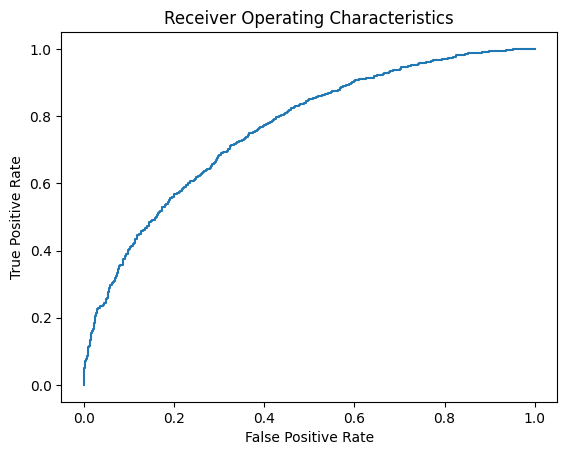

In [212]:
df = df.dropna()
df = df[~(df == .5).any(axis=1)]
# df = df[~(df == -20).any(axis=1)]
# df = df[(df['surface_Hard'] == 1.0)]


odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index

df = df.drop(columns=['a_odds', 'b_odds'])

y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1).values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, odds_df['index'].values, test_size=0.2, random_state=42
)

# Set target accuracy
target_accuracy = 0.6885

final_acc = 0.0
while final_acc < target_accuracy:
    best_acc, best_model_weights = cross_validate(OutcomeProbabilityV6, X_train, y_train, epochs=100, target_accuracy=target_accuracy)
    print(f"Best cross-validated accuracy: {best_acc*100:.2f}%")

    # Final training on full training data
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
    val_data = TensorDataset(X_test_tensor, y_test_tensor)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=False)

    model = OutcomeProbabilityV6(input_dim=X.shape[1])
    model.load_state_dict(best_model_weights)
    final_acc, _ = train_and_evaluate(model, train_loader, val_loader, epochs=100, target_accuracy=target_accuracy)
    print(f"Final model accuracy on test set: {final_acc*100:.2f}%")

    if final_acc < target_accuracy:
        print(f"Accuracy {final_acc*100:.2f}% not met, restarting the process.")
    # Quick train break
    # break

# Evaluate and store predictions
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_test_np = y_test_tensor.numpy()
    odds_test = odds_df.loc[idx_test].values

    # Create DataFrame with predictions and actual values
    results_df = pd.DataFrame({
        'Actual': y_test_np.flatten(),
        'Predicted': y_pred.flatten(),
        'A_Odds': odds_test[:, 0],
        'B_Odds': odds_test[:, 1]
    })

    # Optionally save to CSV
    results_df.to_csv('predictions_with_odds.csv', index=False)

# Plot ROC curve
with torch.no_grad():
    fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred)
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [213]:
# Display the DataFrame
# results_df.head()
print(results_df)

      Actual  Predicted  A_Odds  B_Odds
0        1.0   0.493235    2.45    1.53
1        0.0   0.661520    1.63    2.25
2        1.0   0.555086    1.42    2.76
3        1.0   0.748519    1.19    4.53
4        1.0   0.529935    1.43    2.78
...      ...        ...     ...     ...
1947     1.0   0.670989    1.36    3.03
1948     1.0   0.511616    1.58    2.33
1949     0.0   0.693161    1.33    3.24
1950     0.0   0.186464    3.12    1.36
1951     0.0   0.433813    3.10    1.36

[1952 rows x 4 columns]


In [214]:
# Kelly Criterion
def kelly_criterion(vegas_odds, calculated_probability):
    # Calculate the Kelly fraction
    kelly_fraction = (vegas_odds * calculated_probability - (1 - calculated_probability)) / vegas_odds
    
    # Ensure that the fraction is not negative
    kelly_fraction = max(0, kelly_fraction)
    
    return kelly_fraction

In [215]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

upset_predict = 0
upset_correct = 0
upset_won = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = results_df.dropna()
length = len(comparison_df)

confidence_pct = .5
confidence_top_pct = 1

UNIT = 10

for i, row in comparison_df.iterrows():

    if confidence_top_pct > row['Predicted'] > confidence_pct :#and row['Predicted'] > 1/row['A_Odds'] + .03:
        better += 1
        if(row['Actual'] == 1):
            bet_correct += 1
            total_won += (row['A_Odds']-1) * UNIT #(kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)
        else:
            wrong += 1
            total_won -= UNIT #(kelly_criterion(row['A_Odds'],row['Predicted']) * UNIT)

    if 1-confidence_top_pct < row['Predicted'] < 1-confidence_pct :# and 1-row['Predicted'] > 1/row['B_Odds']+ .03:
        better += 1
        if(row['Actual'] == 0):
            bet_correct += 1
            total_won += (row['B_Odds']-1) * UNIT #(kelly_criterion(row['B_Odds'],row['Predicted']) * UNIT)
        else:
            wrong += 1
            total_won -= UNIT #(kelly_criterion(row['B_Odds'],row['Predicted']) * UNIT)

    if round(row['Predicted']) != round(1/row['A_Odds']):
        upset_predict += 1
        if round(row['Predicted']) == round(row['Actual']):
            upset_correct += 1
            if(row['Actual'] == 1):
                upset_won += (row['A_Odds']-1) * UNIT
            else:
                upset_won += (row['B_Odds']-1) * UNIT
        else:
            upset_won -= UNIT

    if round(row['Predicted']) != round(1/row['A_Odds']):
        diff_fav += 1

    if row['Actual']==1 and row['A_Odds'] < row['B_Odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['A_Odds'] > row['B_Odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total won on ${UNIT} bets: {total_won:.2f} on a total # bets: {better} from a total of {length} games")
print(f"Amount of differing favorites {diff_fav/length}")
print(f"Amount of upset correct {upset_correct/upset_predict} won ${upset_won} on {upset_predict} bets")
print(f"Amount of incorrect bets : {wrong/better}")
print(f"Correct Bets: {bet_correct/better}")
print(f"Model % Correct : {model_correct/length} Vegas Correct % : {vegas_correct/length}")


Total won on $10 bets: -597.20 on a total # bets: 1952 from a total of 1952 games
Amount of differing favorites 0.12192622950819672
Amount of upset correct 0.4831932773109244 won $91.59999999999998 on 238 bets
Amount of incorrect bets : 0.3099385245901639
Correct Bets: 0.6900614754098361
Model % Correct : 0.6900614754098361 Vegas Correct % : 0.6987704918032787
